# Prédictions à partir de la première Base de Données

Dans un premier temps, nous allons tenter de prédire les résultats de Ligue 1 pour la saison en cours, à partir d'une base de donnée constituée de certaines données basiques sur l'ensemble des saisons depuis 2002-2003. Ces données seront, pour chaque match: la journée, le lieu du match, les deux équipes, le score, le classement des deux équipes. A partir de ces données nous allons pouvoir créer différents indicateurs comme la moyenne de buts marqués ou encore la forme des équipes et essayer de prédire les futures résultats. 

In [63]:
import pandas as pd
import numpy as np 
import openpyxl
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re
from IPython.display import display


## Scrapping des données 

Nous commençons par scrapper nos données. Nous scrappons d'abord l'ensemble des résultats sur le site *fbref.com*. Nous créons à partir de ce scrapping un **DataFrame** avec 7 colonnes:

la saison, la journée, l'équipe domicile, l'équipe extérieur, le nombre de buts de l'équipe domicile, le nombre de buts de l'équipe extérieure et le résultat (1 = victoire domicile, 0 = match nul, -1 = victoire extérieur)

On enregistre le **DataFrame** au format csv.

In [3]:
def fonction_resultats(i):
    url = 'https://fbref.com/en/comps/13/' + str(i) +'-' + str(i+1) + '/schedule/' + str(i) +'-' + str(i+1) + '-Ligue-1-Scores-and-Fixtures'
    page = requests.get(url)
    html_content = page.content
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table))[0].dropna(subset = 'Wk').dropna(subset = 'Score').reset_index(drop=True)
    df = df[['Wk', 'Home', 'Score', 'Away']]
    noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
    df.insert(0,'Saison', str(i) + '-' + str(i+1))
    df['Buts domicile'] = df['Score'].str[0].astype(int)
    df['Buts extérieur'] = df['Score'].str[2].astype(int)
    df.drop(['Score'], axis = 1, inplace = True)
    df['Résultat'] = -1
    df.loc[df['Buts domicile'] > df['Buts extérieur'], 'Résultat'] = 1
    df.loc[df['Buts domicile'] == df['Buts extérieur'], 'Résultat'] = 0
    df.columns = noms_colonnes
    df['Journée'] = df['Journée'].astype(int)
    return df

noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
dataframe_resultats = pd.DataFrame(columns=noms_colonnes)
for i in range (2002, 2023):
    try:
        resultats_finaux = fonction_resultats(i)
        dataframe_resultats = dataframe_resultats._append(resultats_finaux, ignore_index=True)
    except Exception as e:
        print(f"Erreur à l'élément {i}: {e}")

dataframe_resultats.to_csv('dataframe_résultats.csv', encoding = 'utf-8', index=False)


## Création du **DataFrame** final pour l'implémentation de modèles prédictifs

A partir de ce **DataFrame**, nous créons un nouveau **DataFrame** avec l'ensemble des informations que nous souhaitions avoir pour tenter de prédire les résultats futurs. Nous remplaçons 'Equipe à Domicile', 'Equipe à l'extérieur' par 'Equipe 1', 'Equipe 2', nous ajoutons une colonne valant si l'Equipe 1 est à domicile, 0 sinon, et nous créons un double de notre **DataFrame** en inversant Equipe 1 et Equipe 2, puis nous ajoutons les deux **DataFrame** de sorte à avoir, pour chaque équipe, l'ensemble de ses matchs en tant qu'Equipe 1. Ensuite nous ajoutons le classement à chaque journée des équipes de sorte à avoir pour chaque match le classement des deux équipes avant le match. Nous créons alors les colonnes suivantes : 'Moyenne buts marqués par 1', 'Moyennes buts marqués par 2', 'Moyenne buts marqués par 1 à domicile', 'Moyenne buts marqués par 1 à l'extérieur', 'Moyenne buts marqués par 2 à domicile', 'Moyenne buts marqués par 2 à l'extérieur', 'Moyenne buts encaissés par 1', 'Moyenne buts encaissés par 2','Moyenne buts encaissés par 1 à domicile', 'Moyenne buts encaissés par 1 à l'extérieur', 'Moyenne buts encaissés par 2 à domicile', 'Moyenne buts encaissés par 2 à l'extérieur', 'Forme Equipe 1', 'Forme Equipe 2' et  'Historique des confrontations'. La forme est un indicateur sur les 5 derniers matchs d'une équipe dans la saison, simplement en faisant la somme des résultats. *Toutes ces variables sont des données avant le match auquel elles sont liés*

On enregistre le **DataFrame** au format csv 

In [55]:
dataframe_final = pd.read_csv('dataframe_résultats.csv', encoding = 'utf-8')

dataframe_final.insert(4, 'Equipe 1 à Domicile', 1)
noms_colonnes = ['Saison', 'Journée', 'Equipe 1', 'Equipe 2', 'Equipe 1 à Domicile', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat']
dataframe_final.columns = noms_colonnes
dataframe_final_copie = dataframe_final.copy()[['Saison', 'Journée', 'Equipe 2', 'Equipe 1', 'Equipe 1 à Domicile', 'Buts Equipe 2', 'Buts Equipe 1', 'Résultat']]
dataframe_final_copie.columns = noms_colonnes
dataframe_final_copie['Equipe 1 à Domicile'] = 0
dataframe_final = dataframe_final._append(dataframe_final_copie, ignore_index=True)
dataframe_final = dataframe_final.sort_values(by=['Saison', 'Equipe 1', 'Journée']).reset_index(drop=True)
conditions = [
    (dataframe_final['Buts Equipe 1'] > dataframe_final['Buts Equipe 2']),
    (dataframe_final['Buts Equipe 1'] < dataframe_final['Buts Equipe 2'])
]
valeurs = [1, -1]
dataframe_final['Résultat'] = 0
dataframe_final['Résultat'] = np.select(conditions, valeurs)

dataframe_final['GF'] = dataframe_final['Buts Equipe 1'].astype(float).astype(int)
dataframe_final['GA'] = dataframe_final['Buts Equipe 2'].astype(float).astype(int)

# Ajout de colonnes pour la différence de buts
dataframe_final['GD'] = dataframe_final['GF']- dataframe_final['GA']
dataframe_final
dataframe_final['Points'] = dataframe_final['Résultat'].map({1: 3, 0: 1, -1: 0})

dataframe_final.sort_values(by=['Saison', 'Journée', 'Equipe 1']).reset_index()
result = dataframe_final.groupby(['Saison', 'Equipe 1']).agg({
    'Points': 'cumsum',
    'GD': 'cumsum',
    'GF': 'cumsum',
    'GA' : 'cumsum'
}).reset_index()

dataframe_final[['CPoints', 'CGD', 'CGF', 'CGA']] = result[['Points', 'GD', 'GF', 'GA']]
dataframe_final = dataframe_final.sort_values(by=['Saison', 'Journée', 'CPoints', 'CGD', 'CGF'], ascending=[True, True, False, False, False]).reset_index()
dataframe_final['Classement Equipe 1'] = dataframe_final.groupby(['Saison', 'Journée']).cumcount() + 1
dataframe_final['Classement Equipe 1'] = dataframe_final.groupby(['Saison','Equipe 1'])['Classement Equipe 1'].shift(1).astype(pd.Int64Dtype())

dataframe_final = dataframe_final.sort_values(by=['Saison', 'Equipe 1', 'Journée']).reset_index(drop=True).drop(['index','Points', 'GD', 'GF', 'GA','CPoints', 'CGD', 'CGF', 'CGA'], axis=1)
dataframe_final['Classement Equipe 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Classement Equipe 1_y']
dataframe_final['Moyenne_BM par 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].transform(lambda x: x.shift(1).expanding().mean())
dataframe_final['Moyenne_BM par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BM par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) / 
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BM par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final['Moyenne_BM par 2 à Domicile'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 à Domicile_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BM par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BM par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final['Moyenne_BM par 2 à Extérieur'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 à Extérieur_y']
dataframe_final['Moyenne_BE par 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].transform(lambda x: x.shift(1).expanding().mean())
dataframe_final['Moyenne_BE par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BE par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BE par 1 à Domicile'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final['Moyenne_BE par 2 à Domicile'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 à Domicile_y']
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BE par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
)
dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BE par 1 à Extérieur'] = (
    (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum()) 
    / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount()))
dataframe_final['Moyenne_BE par 2 à Extérieur'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 à Extérieur_y']
dataframe_final['Forme 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Résultat'].rolling(window=6, min_periods=2).sum().reset_index(drop=True)-dataframe_final['Résultat']
dataframe_final['Forme 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Forme 1_y']
dataframe_final['Historique'] = dataframe_final.groupby(['Equipe 1', 'Equipe 2'])['Résultat'].cumsum() - dataframe_final['Résultat']


dataframe_final.to_csv('dataframe_final.csv', encoding = 'utf-8', index=False)


## Statistiques descriptives 

Dans cette première approche nous avons beaucoup d'observations mais assez peu de variables en comparaison avec notre deuxième approche. Nous pouvons tout de même visualiser quelques statistiques descriptives. 

*On peut d'abord regarder à quoi ressemble notre **DataFrame** avec les 10 premières lignes*

In [56]:
dataframe_final.head(10)

,Saison,Journée,Equipe 1,Equipe 2,Equipe 1 à Domicile,Buts Equipe 1,Buts Equipe 2,Résultat,Classement Equipe 1,Classement Equipe 2,...,Moyenne_BM par 2 à Extérieur,Moyenne_BE par 1,Moyenne_BE par 2,Moyenne_BE par 1 à Domicile,Moyenne_BE par 2 à Domicile,Moyenne_BE par 1 à Extérieur,Moyenne_BE par 2 à Extérieur,Forme 1,Forme 2,Historique
0,2002-2003,1,Ajaccio,Strasbourg,0,1,1,0,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2002-2003,2,Ajaccio,Guingamp,1,0,2,-1,9,7,...,NaN,1.000000,3.000000,NaN,3.000000,1.000000,NaN,0.0,0.0,0
2,2002-2003,3,Ajaccio,Paris S-G,0,2,2,0,16,6,...,0.000000,1.500000,0.000000,2.000000,0.000000,1.000000,0.0,-1.0,1.0,0
3,2002-2003,4,Ajaccio,Sedan,1,1,0,1,15,19,...,1.000000,1.666667,2.333333,2.000000,0.500000,1.500000,6.0,-1.0,-2.0,0
4,2002-2003,5,Ajaccio,Troyes,0,0,1,-1,13,17,...,0.000000,1.250000,1.500000,1.000000,3.000000,1.500000,0.0,0.0,-2.0,0
5,2002-2003,6,Ajaccio,Montpellier,1,0,0,0,15,17,...,0.500000,1.200000,1.000000,1.000000,0.333333,1.333333,2.0,-1.0,-2.0,0
6,2002-2003,7,Ajaccio,Bastia,0,2,1,1,15,12,...,0.333333,1.000000,1.333333,0.666667,0.666667,1.333333,2.0,-1.0,-1.0,0
7,2002-2003,8,Ajaccio,Sochaux,1,0,1,-1,12,10,...,0.750000,1.000000,1.142857,0.666667,1.333333,1.250000,1.0,1.0,1.0,0
8,2002-2003,9,Ajaccio,Marseille,0,1,3,-1,13,4,...,1.750000,1.000000,1.000000,0.750000,1.000000,1.250000,1.0,0.0,2.0,0
9,2002-2003,10,Ajaccio,Nantes,1,1,0,1,17,13,...,1.000000,1.222222,1.555556,0.750000,1.500000,1.600000,1.6,-2.0,-3.0,0


*Affichons ensuites les occurences du nombre de buts par matchs par saison*

In [39]:
display(dataframe_final.groupby(['Saison'])['Buts Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Buts Equipe 1,0,1,2,3,4,5,6,7,8,9
Saison,,,,,,,,,,
2002-2003,277,251,147,56,24,2,3,0,0,0
2003-2004,250,269,147,62,26,5,1,0,0,0
2004-2005,268,265,152,54,13,7,0,0,1,0
2005-2006,278,273,129,51,25,0,2,1,1,0
2006-2007,250,272,150,71,15,2,0,0,0,0
2007-2008,262,258,141,77,15,5,2,0,0,0
2008-2009,240,273,172,59,16,0,0,0,0,0
2009-2010,241,274,139,68,30,8,0,0,0,0
2010-2011,233,272,177,55,17,5,1,0,0,0


*Puis par équipe*

In [47]:
display(dataframe_final.groupby(['Equipe 1'])['Buts Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Buts Equipe 1,0,1,2,3,4,5,6,7,8,9
Equipe 1,,,,,,,,,,
Ajaccio,126,113,49,11,5,0,0,0,0,0
Amiens,41,37,18,6,2,0,0,0,0,0
Angers,102,106,59,23,2,2,0,0,0,0
Arles-Avignon,23,11,2,2,0,0,0,0,0,0
Auxerre,135,149,95,24,13,2,0,0,0,0
Bastia,119,104,56,17,8,0,0,0,0,0
Bordeaux,212,270,159,75,27,4,3,0,0,0
Boulogne,19,10,6,3,0,0,0,0,0,0
Brest,82,99,58,10,4,3,0,0,0,0


*Affichons le nombre de journées occupé à chaque place par chaque équipe (manque pour chaque saison le classement après la dernière journée)*

In [49]:
display(dataframe_final.groupby(['Equipe 1'])['Classement Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Classement Equipe 1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Equipe 1,,,,,,,,,,,,,,,,,,,,
Ajaccio,0,1,0,1,0,1,3,3,3,3,3,4,15,12,30,35,42,51,45,44
Amiens,0,0,0,0,0,0,0,1,2,1,1,2,15,6,9,19,23,12,9,1
Angers,3,13,13,6,8,6,8,18,18,23,16,37,15,29,12,7,9,6,13,26
Arles-Avignon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,35
Auxerre,8,19,17,38,34,21,20,9,12,21,13,21,22,28,24,25,28,18,16,13
Bastia,1,3,4,3,8,4,5,10,14,19,19,29,38,29,29,22,10,14,27,8
Bordeaux,27,67,38,41,42,61,64,54,66,45,38,39,39,28,18,17,12,10,13,11
Boulogne,0,0,0,0,0,0,1,2,0,0,1,1,0,1,0,2,1,1,26,1
Brest,2,1,1,1,3,3,4,5,5,11,21,29,31,33,27,22,15,16,11,8


*Affichons les résultats de chaque équipe*

In [54]:
resultats_counts =  dataframe_final.groupby('Equipe 1')['Résultat'].value_counts().unstack().fillna(0).astype(int)
resultats_counts.columns = ['Défaite', 'Nul', 'Victoire']
display(resultats_counts)

,Défaite,Nul,Victoire
Equipe 1,,,
Ajaccio,147,91,66
Amiens,48,31,25
Angers,133,79,82
Arles-Avignon,24,11,3
Auxerre,144,120,154
Bastia,133,80,91
Bordeaux,226,234,290
Boulogne,21,10,7
Brest,113,73,70


*Affichons les résultats en fonction du classement avant le match*

In [56]:
resultats_counts =  dataframe_final.groupby('Classement Equipe 1')['Résultat'].value_counts().unstack().fillna(0).astype(int)
resultats_counts.columns = ['Défaite', 'Nul', 'Victoire']
display(resultats_counts)

,Défaite,Nul,Victoire
Classement Equipe 1,,,
1,144,184,446
2,209,204,366
3,209,201,351
4,221,233,322
5,249,226,291
6,235,218,313
7,263,218,287
8,268,223,269
9,278,240,269


*Affichons les résultats en fonction de Domicile/Extérieur*

In [70]:
resultats_counts =  dataframe_final.groupby('Equipe 1 à Domicile')['Résultat'].value_counts().unstack().fillna(0).astype(int).reset_index(drop=False)
resultats_counts.columns = ['Lieu','Défaite', 'Nul', 'Victoire']
resultats_counts['Lieu'] = resultats_counts['Lieu'].map({0: 'Extérieur', 1: 'Domicile'})
display(resultats_counts.style.hide_index())

C:\Users\vtgra\AppData\Local\Temp\ipykernel_89016\903187926.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(resultats_counts.style.hide_index())


Lieu,Défaite,Nul,Victoire
Extérieur,3548,2208,2123
Domicile,2123,2208,3548


*Affichons le nombre de buts marqué en fonction de Domicile/Extérieur*

In [69]:
resultats_counts =  dataframe_final.groupby('Equipe 1 à Domicile')['Buts Equipe 1'].value_counts().unstack().fillna(0).astype(int).reset_index(drop=False)
resultats_counts= resultats_counts.rename(columns={'Equipe 1 à Domicile': 'Lieu'})
resultats_counts['Lieu'] = resultats_counts['Lieu'].map({0: 'Extérieur', 1: 'Domicile'})
display(resultats_counts.style.hide_index())  

C:\Users\vtgra\AppData\Local\Temp\ipykernel_89016\3412329827.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(resultats_counts.style.hide_index())


Lieu,0,1,2,3,4,5,6,7,8,9
Extérieur,2883,2805,1439,535,165,39,8,4,0,1
Domicile,1943,2729,1856,873,341,97,33,3,3,1


*Affichons les résultats en fonction de la forme des équipes.*

*La valeur de forme est égale à (nombre de victoires - nombre de défaites) sur les 5 derniers matchs*

In [58]:
resultats_counts =  dataframe_final.groupby('Forme 1')['Résultat'].value_counts().unstack().fillna(0).astype(int)
resultats_counts.columns = ['Défaite', 'Nul', 'Victoire']
display(resultats_counts)

,Défaite,Nul,Victoire
Forme 1,,,
-5.0,84,40,23
-4.0,178,121,138
-3.0,488,302,338
-2.0,751,547,617
-1.0,1032,780,878
0.0,1028,787,1019
1.0,895,728,989
2.0,590,527,680
3.0,326,297,488


*Affichons un tableau à double entrée des historiques entre les équipes (pour chaque confrontation il manque le résultat du dernier match).*

*La valeur affichée représente (nombre de victoires - nombre de défaites) de l'Equipe 1 contre l'Equipe 2*

In [47]:
display(pd.pivot_table(dataframe_final, values='Historique', index='Equipe 1', columns='Equipe 2', aggfunc='last').fillna(0).astype(int))

Equipe 2,Ajaccio,Amiens,Angers,Arles-Avignon,Auxerre,Bastia,Bordeaux,Boulogne,Brest,Caen,...,Paris S-G,Reims,Rennes,Saint-Étienne,Sedan,Sochaux,Strasbourg,Toulouse,Troyes,Valenciennes
Equipe 1,,,,,,,,,,,,,,,,,,,,,
Ajaccio,0,0,1,0,-2,1,-5,0,2,0,...,-4,0,-4,-3,1,-2,-1,-1,-4,0
Amiens,0,0,-2,0,0,0,0,0,1,-1,...,-4,1,-2,-2,0,0,0,-1,-1,0
Angers,-1,2,0,0,0,1,1,0,1,5,...,-13,-2,-7,-5,0,0,0,-3,2,0
Arles-Avignon,0,0,0,0,-1,0,-1,0,0,1,...,-1,0,-1,-1,0,-1,0,-1,0,-1
Auxerre,2,0,0,1,0,0,-2,0,-1,2,...,-4,-1,3,0,2,7,3,3,4,0
Bastia,-1,0,-1,0,0,0,1,0,-1,2,...,-9,1,4,-8,-1,-1,-1,6,0,1
Bordeaux,5,0,-1,1,2,-1,0,1,-1,-1,...,-8,-4,6,6,2,7,-5,1,7,4
Boulogne,0,0,0,0,0,0,-1,0,0,0,...,-1,0,-1,1,0,0,0,-1,0,0
Brest,-2,-1,-1,0,1,1,1,0,0,0,...,-11,-1,-6,1,0,0,-2,-3,2,2


C:\Users\vtgra\AppData\Local\Temp\ipykernel_67084\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


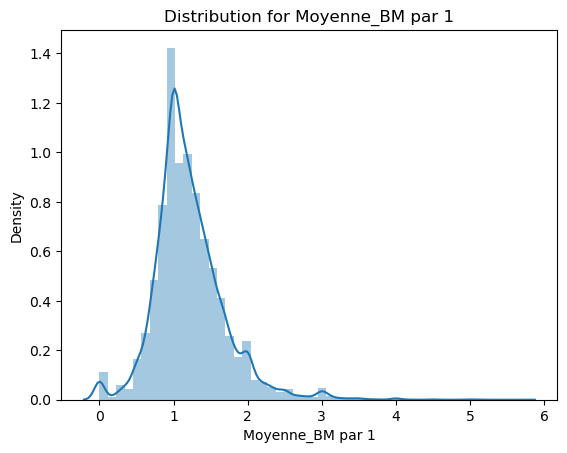

C:\Users\vtgra\AppData\Local\Temp\ipykernel_67084\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


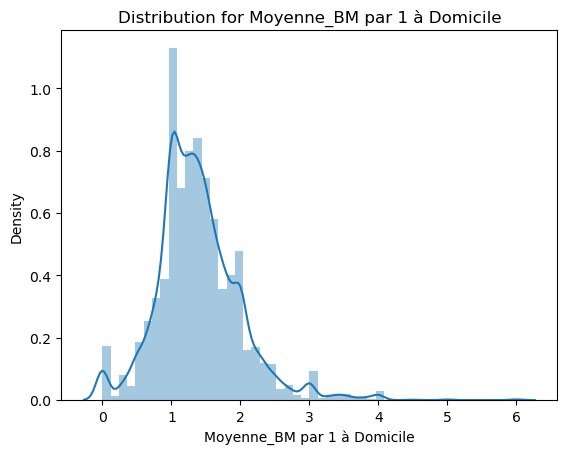

C:\Users\vtgra\AppData\Local\Temp\ipykernel_67084\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


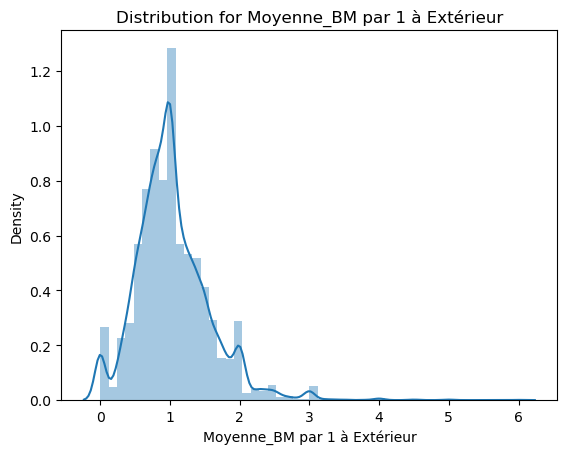

C:\Users\vtgra\AppData\Local\Temp\ipykernel_67084\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


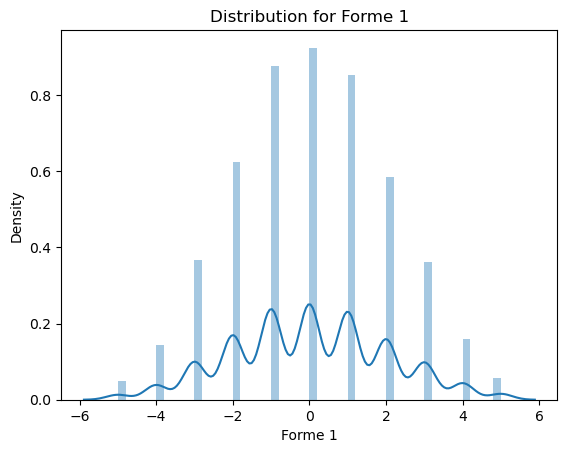

C:\Users\vtgra\AppData\Local\Temp\ipykernel_67084\1270488708.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


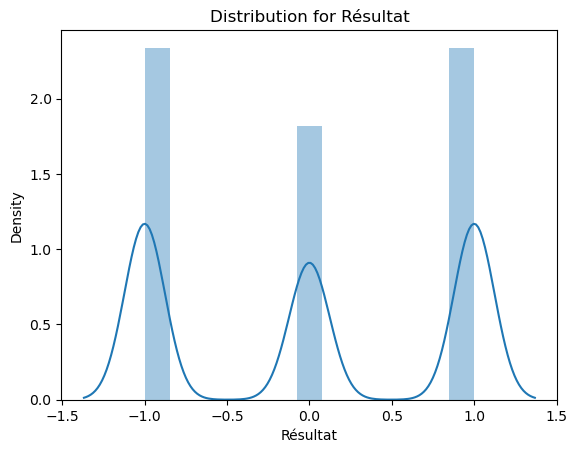

In [61]:
dataframe_plot = dataframe_final[['Moyenne_BM par 1','Moyenne_BM par 1 à Domicile', 'Moyenne_BM par 1 à Extérieur', 'Forme 1','Résultat']]
for col in dataframe_plot.select_dtypes('number').columns:
    sns.distplot(dataframe_plot[col])
    plt.title(f"Distribution for {col}")
    plt.show()

## Modélisation

Passons maintenant à la phase modélisation. Nous allons ici tester 3 modèles en modifiant les variables explicative et même la variable expliquée. Ces modèles sont : **modèle de régression linéaire**, **Random Forest** et **modèle SVM**

Dans un premier temps, applicons ses 3 modèles avec comme variable expliquée le **Résultat**, et le reste des données numériques comme variables explicatives

In [74]:
model = sm.OLS
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
X = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
X = sm.add_constant(X)
Y = dataframe_regression[["Résultat"]]
Z = dataframe_regression[["Buts Equipe 1"]]
W = dataframe_regression[["Buts Equipe 2"]]
X_train, X_test, Y_train, Y_test, Z_train, Z_test, W_train, W_test = train_test_split(X, Y, Z, W, test_size=0.2, random_state=42)

#Régression sur le résultat
results = model(X_train, Y_train).fit()

print(results.summary())

Y_pred = model.predict(X_test)

Y_pred = [element for sous_liste in Y_pred for element in sous_liste]
Y_pred = [-1 if x < 0 else 1 for x in Y_pred]
Y_test = Y_test[Y_test.columns[0]] .tolist()

bon_résultat = [a == b for a, b in zip(Y_pred, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur le Résultat')
print('accuracy: ', accuracy)


#Régression sur les Scores dont on déduit un Résultat


model.fit(X_train, Z_train)
Z_pred = model.predict(X_test)
Z_pred = [element for sous_liste in Z_pred for element in sous_liste]
Z_test = Z_test[Z_test.columns[0]] .tolist()

model.fit(X_train, W_train)
W_pred = model.predict(X_test)
W_pred = [element for sous_liste in W_pred for element in sous_liste]
W_test = W_test[W_test.columns[0]] .tolist()


resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred2 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred2, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)


#Random Forest sur le résultat
random_forest_model.fit(X_train, Y_train)
Y_pred3 = random_forest_model.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred3)
classification_report_result = classification_report(Y_test, Y_pred3)

print('Random Forest sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

#SVM model sur le résultat
svm_model.fit(X_train, Y_train)

Y_pred4 = svm_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred4)
classification_report_result = classification_report(Y_test, Y_pred4)

print('SVM model sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)





ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [63]:
n=0
for i in np.arange(0,2,0.4):  
    for j in np.arange(0,2,0.4): 
        for k in np.arange(0,2,0.4): 
            for l in np.arange(0,2,0.4): 
                resultat = [-1 if (i*a +j*b + k*c + l*d) < 0 else 1 for a, b, c, d in zip(Y_pred, Y_pred2, Y_pred3, Y_pred4) ]
                bon_résultat = [a == b for a, b in zip(resultat, Y_test)]
                accuracy = (sum(bon_résultat) / len(bon_résultat)) 
                if accuracy>n:
                    n=accuracy
print('Régression sur le Résultat')
print('accuracy: ', accuracy)


Régression sur le Résultat
accuracy:  0.4904330312185297


In [53]:
#Random Forest sur le Score
random_forest_model.fit(X_train, Z_train)
Z_pred= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, W_train)
W_pred = random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Z_test, Z_pred)
classification_report_result1 = classification_report(Z_test, Z_pred)

accuracy2 = accuracy_score(W_test, W_pred)
classification_report_result2 = classification_report(W_test, W_pred)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred5 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred5, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur Buts Equipe 1
Accuracy: 0.3545
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.45      0.42       893
           1       0.35      0.56      0.43      1034
           2       0.28      0.10      0.15       646
           3       0.21      0.03      0.05       252
           4       0.50      0.01      0.02       120
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2

    accuracy                           0.35      2979
   macro avg       0.21      0.14      0.13      2979
weighted avg       0.33      0.35      0.31      2979

Random Forest sur Buts Equipe 2
Accuracy: 0.1735
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.40      0.39       898
           1       0.35      0.55      0.43      1042
           2       0.25      0.14      0

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metr

In [67]:
model = LinearRegression()
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
Y = dataframe_regression[["Résultat"]]
Z = dataframe_regression[["Buts Equipe 1"]]
W = dataframe_regression[["Buts Equipe 2"]]
X_train, X_test, Y_train, Y_test, Z_train, Z_test, W_train, W_test = train_test_split(X, Y, Z, W, test_size=0.2, random_state=42)
#Régression sur le résultat

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

Y_pred = [element for sous_liste in Y_pred for element in sous_liste]
Y_pred = [-1 if x < 0 else 1 for x in Y_pred]
Y_test = Y_test[Y_test.columns[0]] .tolist()

bon_résultat = [a == b for a, b in zip(Y_pred, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur le Résultat')
print('accuracy: ', accuracy)

#Régression sur les Scores dont on déduit un Résultat


model.fit(X_train, Z_train)
Z_pred = model.predict(X_test)
Z_pred = [element for sous_liste in Z_pred for element in sous_liste]
Z_test = Z_test[Z_test.columns[0]] .tolist()

model.fit(X_train, W_train)
W_pred = model.predict(X_test)
W_pred = [element for sous_liste in W_pred for element in sous_liste]
W_test = W_test[W_test.columns[0]] .tolist()


resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred2 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred2, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)


#Random Forest sur le résultat
random_forest_model.fit(X_train, Y_train)
Y_pred3= random_forest_model.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred3)
classification_report_result = classification_report(Y_test, Y_pred3)

print('Random Forest sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

#SVM model sur le résultat
svm_model.fit(X_train, Y_train)

Y_pred4 = svm_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred4)
classification_report_result = classification_report(Y_test, Y_pred4)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)



Régression sur le Résultat
accuracy:  0.4944612286002014
Régression sur les Scores dont on déduit un Résultat
accuracy:  0.49613964417589795


c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur le Résultat
Accuracy: 0.4770
Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.64      0.56      1083
           0       0.27      0.09      0.13       815
           1       0.50      0.61      0.55      1081

    accuracy                           0.48      2979
   macro avg       0.42      0.44      0.41      2979
weighted avg       0.43      0.48      0.44      2979



c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.4867
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.69      0.57      1083
           0       0.26      0.01      0.01       815
           1       0.50      0.64      0.56      1081

    accuracy                           0.49      2979
   macro avg       0.41      0.45      0.38      2979
weighted avg       0.43      0.49      0.41      2979



In [68]:
resultat = [-1 if 0.5*a +0.5*b + c + d < 0 else 1 for a, b, c, d in zip(Y_pred, Y_pred2, Y_pred3, Y_pred4) ]
bon_résultat = [a == b for a, b in zip(resultat, Y_test)]
accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur le Résultat')
print('accuracy: ', accuracy)


Régression sur le Résultat
accuracy:  0.4904330312185297


In [69]:
#Random Forest sur le Score
random_forest_model.fit(X_train, Z_train)
Z_pred= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, W_train)
W_pred = random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Z_test, Z_pred)
classification_report_result1 = classification_report(Z_test, Z_pred)

accuracy2 = accuracy_score(W_test, W_pred)
classification_report_result2 = classification_report(W_test, W_pred)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred2 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred2, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)


c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [71]:
model=LinearRegression()
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat','Moyenne_BM par 1 à Domicile',
                                     'Moyenne_BM par 1 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur','Moyenne_BM par 2 à Domicile',
                                     'Moyenne_BM par 2 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur'], axis = 1)
Y = dataframe_regression[["Résultat"]]
Z = dataframe_regression[["Buts Equipe 1"]]
W = dataframe_regression[["Buts Equipe 2"]]
X_train, X_test, Y_train, Y_test, Z_train, Z_test, W_train, W_test = train_test_split(X, Y, Z, W, test_size=0.2, random_state=42)
#Régression sur le résultat

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

Y_pred = [element for sous_liste in Y_pred for element in sous_liste]
Y_pred = [-1 if x < 0 else 1 for x in Y_pred]
Y_test = Y_test[Y_test.columns[0]] .tolist()

bon_résultat = [a == b for a, b in zip(Y_pred, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur le Résultat')
print('accuracy: ', accuracy)

#Régression sur les Scores dont on déduit un Résultat


model.fit(X_train, Z_train)
Z_pred = model.predict(X_test)
Z_pred = [element for sous_liste in Z_pred for element in sous_liste]
Z_test = Z_test[Z_test.columns[0]] .tolist()

model.fit(X_train, W_train)
W_pred = model.predict(X_test)
W_pred = [element for sous_liste in W_pred for element in sous_liste]
W_test = W_test[W_test.columns[0]] .tolist()


resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred2 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred2, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)


#Random Forest sur le résultat
random_forest_model.fit(X_train, Y_train)
Y_pred3 = random_forest_model.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred3)
classification_report_result = classification_report(Y_test, Y_pred3)

print('Random Forest sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

#SVM model sur le résultat
svm_model.fit(X_train, Y_train)

Y_pred4 = svm_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred4)
classification_report_result = classification_report(Y_test, Y_pred4)

print('SVM Model sur le Résultat')
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)



Régression sur le Résultat
accuracy:  0.4941255454850621
Régression sur les Scores dont on déduit un Résultat
accuracy:  0.4954682779456193


c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur le Résultat
Accuracy: 0.4817
Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.65      0.56      1083
           0       0.27      0.08      0.12       815
           1       0.51      0.61      0.56      1081

    accuracy                           0.48      2979
   macro avg       0.42      0.45      0.41      2979
weighted avg       0.44      0.48      0.44      2979



c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Model sur le Résultat
Accuracy: 0.4871
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.69      0.57      1083
           0       0.38      0.01      0.01       815
           1       0.50      0.65      0.56      1081

    accuracy                           0.49      2979
   macro avg       0.45      0.45      0.38      2979
weighted avg       0.46      0.49      0.41      2979



In [ ]:
resultat = [-1 if 0.5*a +0.5*b + c + d < 0 else 1 for a, b, c, d in zip(Y_pred, Y_pred2, Y_pred3, Y_pred4) ]
bon_résultat = [a == b for a, b in zip(resultat, Y_test)]
accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur le Résultat')
print('accuracy: ', accuracy)

True     398
False    322
Name: Bon résultat, dtype: int64
Résultat final  Bon résultat
-1              True            199
                False           159
 0              False             5
                True              5
 1              True            194
                False           158
Name: Bon résultat, dtype: int64
accuracy: 0.5527777777777778


In [ ]:
#Random Forest sur le Score
random_forest_model.fit(X_train, Z_train)
Z_pred= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, W_train)
W_pred = random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Z_test, Z_pred)
classification_report_result1 = classification_report(Z_test, Z_pred)

accuracy2 = accuracy_score(W_test, W_pred)
classification_report_result2 = classification_report(W_test, W_pred)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred2 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred2, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)

Random Forest sur Buts Equipe 1
Accuracy: 0.3069
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.34      0.33       178
           1       0.35      0.53      0.42       264
           2       0.17      0.13      0.15       158
           3       0.10      0.01      0.02        82
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3

    accuracy                           0.31       720
   macro avg       0.12      0.13      0.11       720
weighted avg       0.26      0.31      0.27       720

Random Forest sur Buts Equipe 2
Accuracy: 0.3014
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.31      0.31       178
           1       0.34      0.53      0.42       264
           2       0.18      0.12      0

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metr